In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


In [8]:
# Load train and test CSV
train_df = pd.read_csv('./mnist-in-csv/mnist_train.csv')
test_df = pd.read_csv('./mnist-in-csv/mnist_test.csv')

# Display sample rows
print("Train data sample:")
train_df.head(3)



Train data sample:


,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
train_df.shape

(60000, 785)

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to 28x28
dtypes: int64(785)
memory usage: 359.3 MB


In [11]:
train_df.isna().sum()

label    0
1x1      0
1x2      0
1x3      0
1x4      0
        ..
28x24    0
28x25    0
28x26    0
28x27    0
28x28    0
Length: 785, dtype: int64

In [6]:
print("\nTest data sample:")
test_df.head(3)


Test data sample:


,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
test_df.shape

(10000, 785)

In [12]:
# Separate features and labels
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values

X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values

# Normalize pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0

# Reshape to 28x28x1 for CNN/GAN
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (60000, 28, 28, 1), Test shape: (10000, 28, 28, 1)


In [13]:
latent_dim = 100


# Generator

In [14]:
# Generator
def build_generator():
    model = Sequential([
        layers.Dense(7*7*128, input_dim=latent_dim),
        layers.Reshape((7, 7, 128)),
        layers.BatchNormalization(),
        layers.UpSampling2D(),
        layers.Conv2D(128, kernel_size=3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.UpSampling2D(),
        layers.Conv2D(64, kernel_size=3, padding='same', activation='relu'),
        layers.Conv2D(1, kernel_size=3, padding='same', activation='sigmoid')
    ])
    return model


# Discriminator

In [15]:
# Discriminator
def build_discriminator():
    model = Sequential([
        layers.Conv2D(64, kernel_size=3, strides=2, input_shape=(28,28,1), padding='same'),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(128, kernel_size=3, strides=2, padding='same'),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model


In [16]:
# Build generator and discriminator
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Combine GAN
discriminator.trainable = False
gan_input = layers.Input(shape=(latent_dim,))
fake_image = generator(gan_input)
gan_output = discriminator(fake_image)
gan = tf.keras.Model(gan_input, gan_output)
gan.compile(optimizer='adam', loss='binary_crossentropy')


d:\MNIST_DigitRecognizer\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
d:\MNIST_DigitRecognizer\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
def train_gan(gan, generator, discriminator, X_train, epochs=100, batch_size=128):
    for epoch in range(epochs):
        # Train Discriminator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_images = generator.predict(noise)

        X = np.concatenate([real_images, fake_images])
        y = np.concatenate([np.ones((batch_size,1)), np.zeros((batch_size,1))])

        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(X, y)

        # Train Generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        y_gen = np.ones((batch_size,1))
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gen)

        if epoch % 10 == 0:  # Reduced for demo
            print(f"Epoch {epoch}: D Loss: {d_loss}, G Loss: {g_loss}")

# Example training call
train_gan(gan, generator, discriminator, X_train, epochs=50, batch_size=128)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 0: D Loss: [array(0.6942842, dtype=float32), array(0.44921875, dtype=float32)], G Loss: 0.8044170141220093
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 10: D Loss: [array(0.42146322, dtype=float32), array(0.8540483, dtype=float32)], G Loss: 0.6701177358627319
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


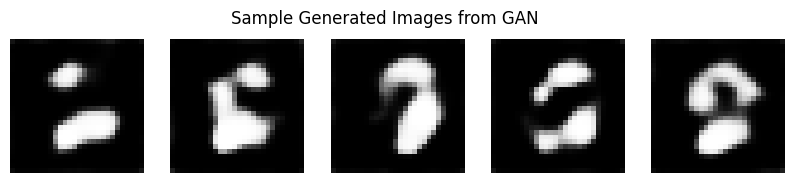

In [19]:
num_samples = 5
noise = np.random.normal(0, 1, (num_samples, latent_dim))
generated_images = generator.predict(noise)

plt.figure(figsize=(10,2))
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(generated_images[i].reshape(28,28), cmap='gray')
    plt.axis('off')
plt.suptitle("Sample Generated Images from GAN")
plt.show()


In [20]:
# Define CNN classifier
cnn = Sequential([
    Conv2D(32, kernel_size=3, activation='relu', input_shape=(28,28,1)),
    MaxPooling2D(),
    Conv2D(64, kernel_size=3, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [21]:
cnn.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9528 - loss: 0.1606 - val_accuracy: 0.9851 - val_loss: 0.0466
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9857 - loss: 0.0476 - val_accuracy: 0.9879 - val_loss: 0.0393
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9899 - loss: 0.0332 - val_accuracy: 0.9889 - val_loss: 0.0322
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9918 - loss: 0.0252 - val_accuracy: 0.9884 - val_loss: 0.0354
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9944 - loss: 0.0187 - val_accuracy: 0.9886 - val_loss: 0.0319


In [24]:
cnn.save("mnist_cnn_model.h5")
print("Model saved as mnist_cnn_model.h5")


Model saved as mnist_cnn_model.h5


In [22]:
# Evaluate on training data
train_loss, train_acc = cnn.evaluate(X_train, y_train, verbose=0)
print(f"✅ Training Accuracy: {train_acc * 100:.2f}%")
print(f"✅ Training Loss: {train_loss:.4f}")

# Evaluate on test (validation) data
test_loss, test_acc = cnn.evaluate(X_test, y_test, verbose=0)
print(f"✅ Validation Accuracy: {test_acc * 100:.2f}%")
print(f"✅ Validation Loss: {test_loss:.4f}")


✅ Training Accuracy: 99.48%
✅ Training Loss: 0.0158
✅ Validation Accuracy: 98.86%
✅ Validation Loss: 0.0319


# Visualize Training Process

In [23]:
history = cnn.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9955 - loss: 0.0143 - val_accuracy: 0.9872 - val_loss: 0.0399
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9963 - loss: 0.0113 - val_accuracy: 0.9898 - val_loss: 0.0297
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9969 - loss: 0.0090 - val_accuracy: 0.9921 - val_loss: 0.0279
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9970 - loss: 0.0085 - val_accuracy: 0.9862 - val_loss: 0.0497
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9971 - loss: 0.0083 - val_accuracy: 0.9923 - val_loss: 0.0233


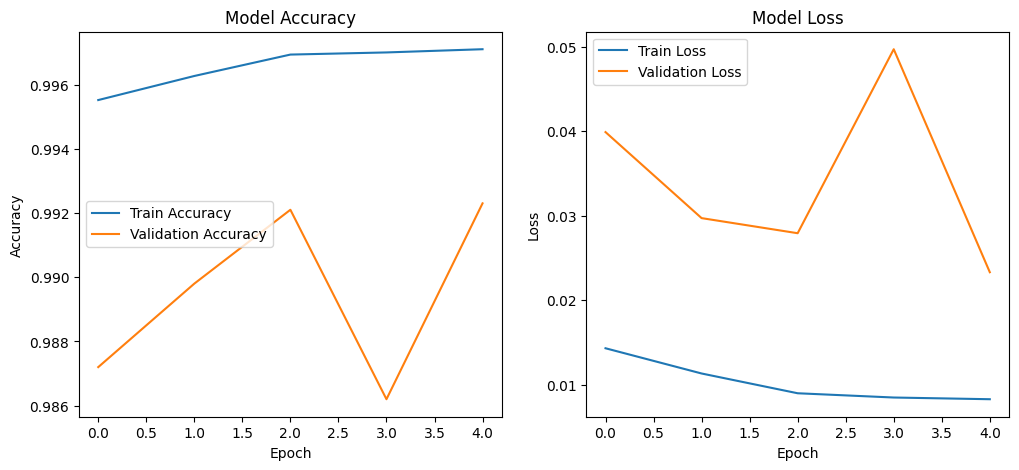

In [25]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [26]:
cnn_loaded = load_model("mnist_cnn_model.h5")


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


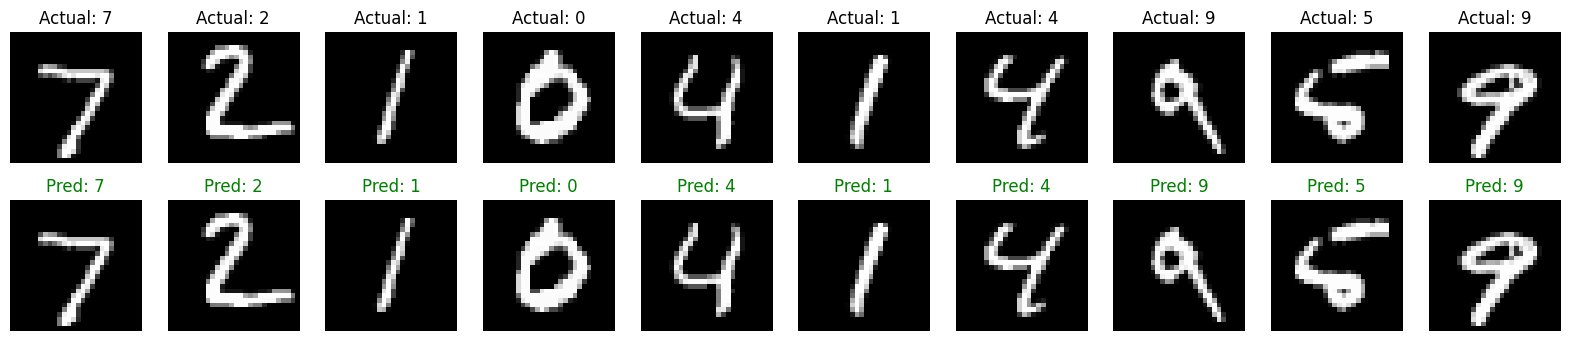

In [27]:
y_pred = cnn_loaded.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

num_examples = 10
plt.figure(figsize=(20, 4))

for i in range(num_examples):
    # Actual
    ax = plt.subplot(2, num_examples, i+1)
    plt.imshow(X_test[i].reshape(28,28), cmap='gray')
    plt.title(f"Actual: {y_test[i]}")
    plt.axis('off')
    
    # Predicted
    ax = plt.subplot(2, num_examples, i+1+num_examples)
    plt.imshow(X_test[i].reshape(28,28), cmap='gray')
    
    # Color green if correct, red if wrong
    color = 'green' if y_pred_labels[i] == y_test[i] else 'red'
    plt.title(f"Pred: {y_pred_labels[i]}", color=color)
    plt.axis('off')

plt.show()


In [29]:
new_df=pd.read_csv('D:/MNIST_DigitRecognizer/MINST_Digit/train.csv')

In [30]:
new_df.head(3)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
new_df.shape

(42000, 785)

In [32]:
# Suppose new_df is your new dataset
X_new = new_df.drop('label', axis=1).values  # or just the image columns if no labels
y_new = new_df['label'].values               # optional, if you want to compare accuracy

# Normalize pixel values
X_new = X_new / 255.0

# Reshape to 28x28x1
X_new = X_new.reshape(-1, 28, 28, 1)


In [33]:
y_pred_new = cnn_loaded.predict(X_new)
y_pred_labels_new = np.argmax(y_pred_new, axis=1)


1313/1313 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [35]:
from sklearn.metrics import accuracy_score, classification_report

# Compute accuracy
acc_new = accuracy_score(y_new, y_pred_labels_new)
print(f"✅ Model Accuracy on new dataset: {acc_new * 100:.2f}%")

# Detailed classification report
print("\n📊 Classification Report:")
print(classification_report(y_new, y_pred_labels_new))


✅ Model Accuracy on new dataset: 99.81%

📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4132
           1       1.00      1.00      1.00      4684
           2       1.00      1.00      1.00      4177
           3       1.00      1.00      1.00      4351
           4       1.00      1.00      1.00      4072
           5       1.00      1.00      1.00      3795
           6       1.00      1.00      1.00      4137
           7       1.00      1.00      1.00      4401
           8       1.00      1.00      1.00      4063
           9       1.00      1.00      1.00      4188

    accuracy                           1.00     42000
   macro avg       1.00      1.00      1.00     42000
weighted avg       1.00      1.00      1.00     42000



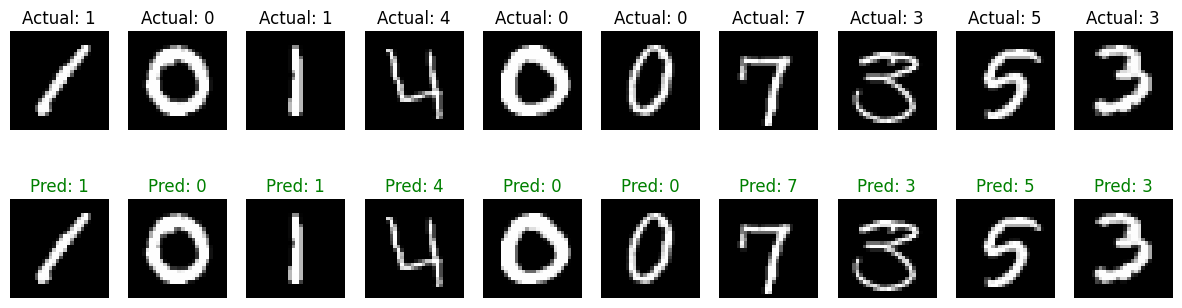

In [34]:
import matplotlib.pyplot as plt

num_examples = 10
plt.figure(figsize=(15, 4))

for i in range(num_examples):
    ax = plt.subplot(2, num_examples, i+1)
    plt.imshow(X_new[i].reshape(28,28), cmap='gray')
    plt.title(f"Actual: {y_new[i]}")
    plt.axis('off')
    
    ax = plt.subplot(2, num_examples, i+1+num_examples)
    plt.imshow(X_new[i].reshape(28,28), cmap='gray')
    color = 'green' if y_pred_labels_new[i] == y_new[i] else 'red'
    plt.title(f"Pred: {y_pred_labels_new[i]}", color=color)
    plt.axis('off')

plt.show()


In [38]:
# If 'label' column is not present
predictions = pd.DataFrame({'Image_ID': range(len(y_pred_labels_new)),
                            'Predicted_Label': y_pred_labels_new})
print(predictions.head(10))


   Image_ID  Predicted_Label
0         0                1
1         1                0
2         2                1
3         3                4
4         4                0
5         5                0
6         6                7
7         7                3
8         8                5
9         9                3


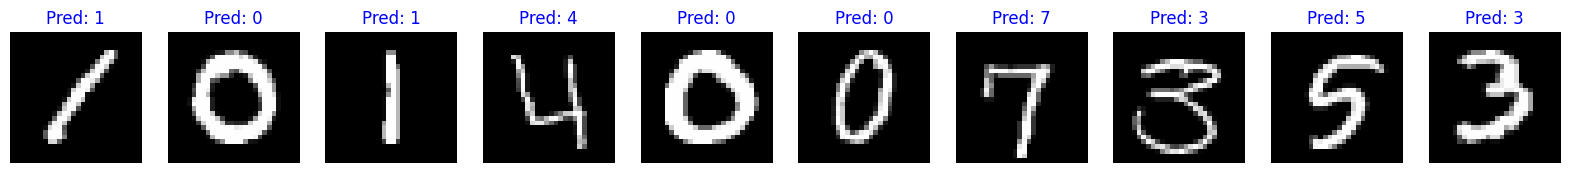

In [37]:
import matplotlib.pyplot as plt
import numpy as np

num_examples = 10
plt.figure(figsize=(20, 4))

for i in range(num_examples):
    ax = plt.subplot(1, num_examples, i+1)
    plt.imshow(X_new[i].reshape(28,28), cmap='gray')
    plt.title(f"Pred: {y_pred_labels_new[i]}", color='blue', fontsize=12)
    plt.axis('off')

plt.show()


In [39]:
import pandas as pd

# Load test dataset
test_df = pd.read_csv('./mnist-in-csv/mnist_test.csv')

# Separate features and labels
X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values

# Normalize pixel values (0–255 → 0–1)
X_test = X_test / 255.0

# Reshape into 28x28 grayscale images
X_test = X_test.reshape(-1, 28, 28, 1)


In [40]:
from sklearn.metrics import accuracy_score, classification_report

# Accuracy
accuracy = accuracy_score(y_test, y_pred_labels)
print(f"✅ Model Accuracy on Test Set: {accuracy * 100:.2f}%")

# Detailed classification report
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred_labels))


✅ Model Accuracy on Test Set: 99.23%

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       1.00      1.00      1.00      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.98      0.99      0.99       958
           7       0.99      1.00      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



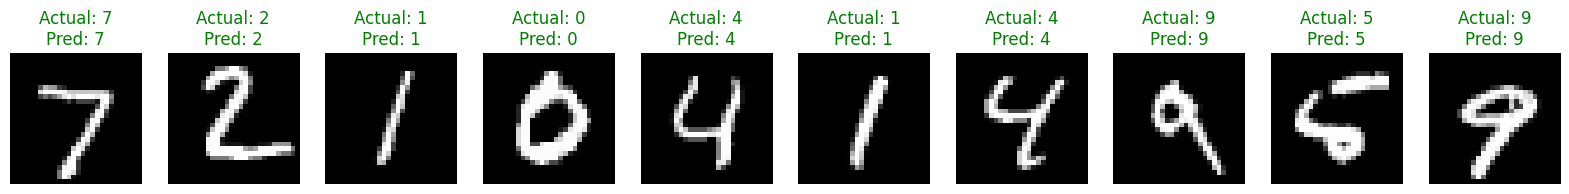

In [41]:
import matplotlib.pyplot as plt

num_examples = 10
plt.figure(figsize=(20, 4))

for i in range(num_examples):
    ax = plt.subplot(2, num_examples, i+1)
    plt.imshow(X_test[i].reshape(28,28), cmap='gray')
    actual, pred = y_test[i], y_pred_labels[i]
    color = 'green' if actual == pred else 'red'
    plt.title(f"Actual: {actual}\nPred: {pred}", color=color)
    plt.axis('off')

plt.show()


In [42]:
import tensorflow as tf
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt


In [43]:
# Replace 'cnn_model.h5' with your saved model path
model = tf.keras.models.load_model("mnist_cnn_model.h5")


In [67]:
# Replace 'sample_digit.png' with your image path
img = Image.open("./sample/7.png").convert("L")  # Convert to grayscale

# Invert colors if needed (white digit on black background)
img = ImageOps.invert(img)

# Resize to 28x28 pixels (MNIST standard)
img = img.resize((28, 28))

# Convert to numpy array and normalize
img_array = np.array(img).reshape(1, 28, 28, 1) / 255.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
✅ Predicted Digit: 7


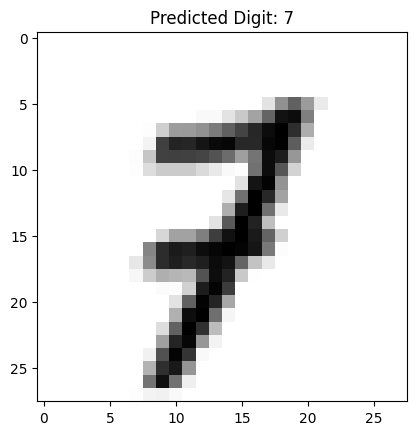

In [68]:
# Get model prediction
prediction = model.predict(img_array)

# Convert to class label
predicted_digit = np.argmax(prediction)
print(f"✅ Predicted Digit: {predicted_digit}")

plt.imshow(img_array.reshape(28,28), cmap='gray')
plt.title(f"Predicted Digit: {predicted_digit}")
plt.axis('on')
plt.show()

In [65]:
# Replace 'sample_digit.png' with your image path
img = Image.open("./sample/1.png").convert("L")  # Convert to grayscale

# Invert colors if needed (white digit on black background)
img = ImageOps.invert(img)

# Resize to 28x28 pixels (MNIST standard)
img = img.resize((28, 28))

# Convert to numpy array and normalize
img_array = np.array(img).reshape(1, 28, 28, 1) / 255.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
✅ Predicted Digit: 1


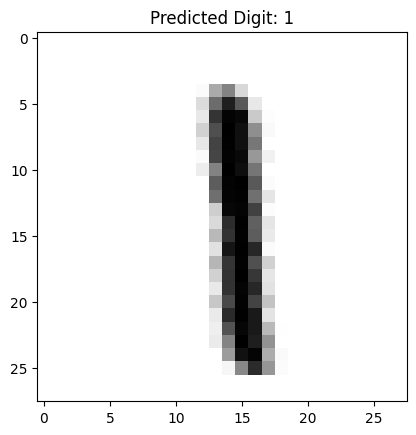

In [66]:
# Get model prediction
prediction = model.predict(img_array)

# Convert to class label
predicted_digit = np.argmax(prediction)
print(f"✅ Predicted Digit: {predicted_digit}")

plt.imshow(img_array.reshape(28,28), cmap='gray')
plt.title(f"Predicted Digit: {predicted_digit}")
plt.axis('on')
plt.show()

In [69]:
# Replace 'sample_digit.png' with your image path
img = Image.open("./sample/8.png").convert("L")  # Convert to grayscale

# Invert colors if needed (white digit on black background)
img = ImageOps.invert(img)

# Resize to 28x28 pixels (MNIST standard)
img = img.resize((28, 28))

# Convert to numpy array and normalize
img_array = np.array(img).reshape(1, 28, 28, 1) / 255.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
✅ Predicted Digit: 8


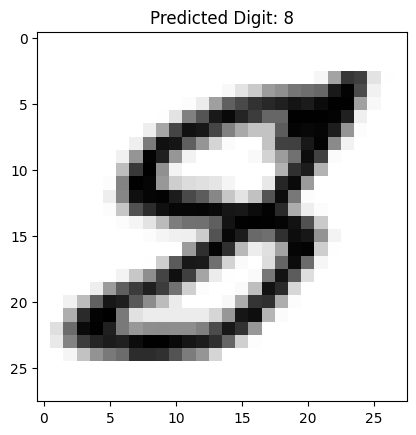

In [70]:
# Get model prediction
prediction = model.predict(img_array)

# Convert to class label
predicted_digit = np.argmax(prediction)
print(f"✅ Predicted Digit: {predicted_digit}")

plt.imshow(img_array.reshape(28,28), cmap='gray')
plt.title(f"Predicted Digit: {predicted_digit}")
plt.axis('on')
plt.show()